# Part 1: Setup and Data Generation

## 1.0 Installing required Python libraries

In [1]:
# !pip install -q xgboost
# !pip install -q faker
# !pip install -q graphviz

## 1.1 Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

## 1.2 Loading from existing data

In [3]:
import pandas as pd

df = pd.read_csv("./data/ecommerce_dataset.csv")

In [4]:
df

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55626,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.0,151
5626,55627,0,13.0,Mobile Phone,1,13.0,Credit Card,Male,3.0,5,Fashion,5,Married,6,0,16.0,1.0,2.0,NaN,225
5627,55628,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.0,186
5628,55629,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.0,179


In [5]:
df.columns

Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [6]:
columns_mapping = {"HourSpendOnApp": "TimeSpentOnSite",
                   "FavoriteCategory": "PreferedOrderCat",
                   "SatisfactionScore": "CustomerSentimentScore",
                   "OrderCount": "TotalPurchases",
                   "DaySinceLastOrder": "LastPurchaseDate",
                   "MembershipLevel": "membershipLevel",
                   "CashbackAmount": "TotalSpent"
                  }
df.rename(columns=columns_mapping, inplace=True)

In [7]:
# Initialize Faker and set random seed for reproducibility
import random
from faker import Faker

fake = Faker()
Faker.seed(0)
random.seed(0)

df["Age"] = random.randint(18, 70)
df["Gender"] = random.choice(["Male", "Female"])
# Website interactions (click rate and time spent)
df["WebSiteClickRate"] = round(random.uniform(0.5, 5), 2)
# Social media engagement and ad click history
df["SocialMediaEngagement"] = random.randint(1, 10)  # engagement score (1 to 10)
df["AdClickHistory"] = random.uniform(0, 1)  # click-through rate between 0 and 1
    

# Part 2: Data Preprocessing and Feature Engineering

## 2.1 Check for Missing Values

- All Missing values less than 6% so we can impute them

In [8]:
# Calculate missing values and their percentages
missing_summary = df.isnull().sum().to_frame(name="Missing Values")
missing_summary["Percentage (%)"] = (missing_summary["Missing Values"] / len(df)) * 100

# Filter to only show columns with missing values
missing_summary = missing_summary[missing_summary["Missing Values"] > 0].round(2)

# Display the table
print(missing_summary)

                             Missing Values  Percentage (%)
Tenure                                  264            4.69
WarehouseToHome                         251            4.46
TimeSpentOnSite                         255            4.53
OrderAmountHikeFromlastYear             265            4.71
CouponUsed                              256            4.55
TotalPurchases                          258            4.58
LastPurchaseDate                        307            5.45


- Imputation steps

In [9]:
df2 = df.copy(deep=True)

In [10]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import seaborn as sns

# Assuming 'df' is the DataFrame loaded with the data
# Reference: Missing values handling section in the PDF

# 1. Handling missing values for 'Tenure' using backward fill
df2['Tenure'] = df2['Tenure'].fillna(df2["Tenure"].median())

# 2. Handling missing values for 'WarehouseToHome' using most frequent value
s_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df2['WarehouseToHome'] = s_imp.fit_transform(df2[['WarehouseToHome']])

# 3. Handling missing values for 'TimeSpentOnSite' using random choice from non-missing values
fill_list = df2['TimeSpentOnSite'].dropna()
df2['TimeSpentOnSite'] = df2['TimeSpentOnSite'].fillna(
    pd.Series(np.random.choice(fill_list, size=len(df2['TotalSpent'].index)))
)

# 4. Handling missing values for 'OrderAmountHikeFromlastYear' using forward fill
df2['OrderAmountHikeFromlastYear'] = df2['OrderAmountHikeFromlastYear'].fillna(df2['LastPurchaseDate'].median())

# 5. Handling missing values for 'CouponUsed' using KNN Imputer
knn_imputer = KNNImputer(n_neighbors=2)
df2['CouponUsed'] = knn_imputer.fit_transform(df2[['CouponUsed']])

# 6. Handling missing values for 'TotalPurchases' using KNN Imputer
knn_imputer_2 = KNNImputer(n_neighbors=2)
df2['TotalPurchases'] = knn_imputer_2.fit_transform(df2[['TotalPurchases']])

# 7. Handling missing values for 'LastPurchaseDate' using backward fill
df2['LastPurchaseDate'] = df2['LastPurchaseDate'].fillna(df2['LastPurchaseDate'].median())

In [11]:
# Visualization to confirm missing values are handled
print("Missing values after imputation:")
print(df2.isnull().sum())

Missing values after imputation:
CustomerID                     0
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
TimeSpentOnSite                0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
CustomerSentimentScore         0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
TotalPurchases                 0
LastPurchaseDate               0
TotalSpent                     0
Age                            0
WebSiteClickRate               0
SocialMediaEngagement          0
AdClickHistory                 0
dtype: int64


- Compare the distribution of columns before and after imputation

It appears that the imputation strategy preserves the original distribution of the dataset, ensuring minimal impact on the data\'s overall characteristics.

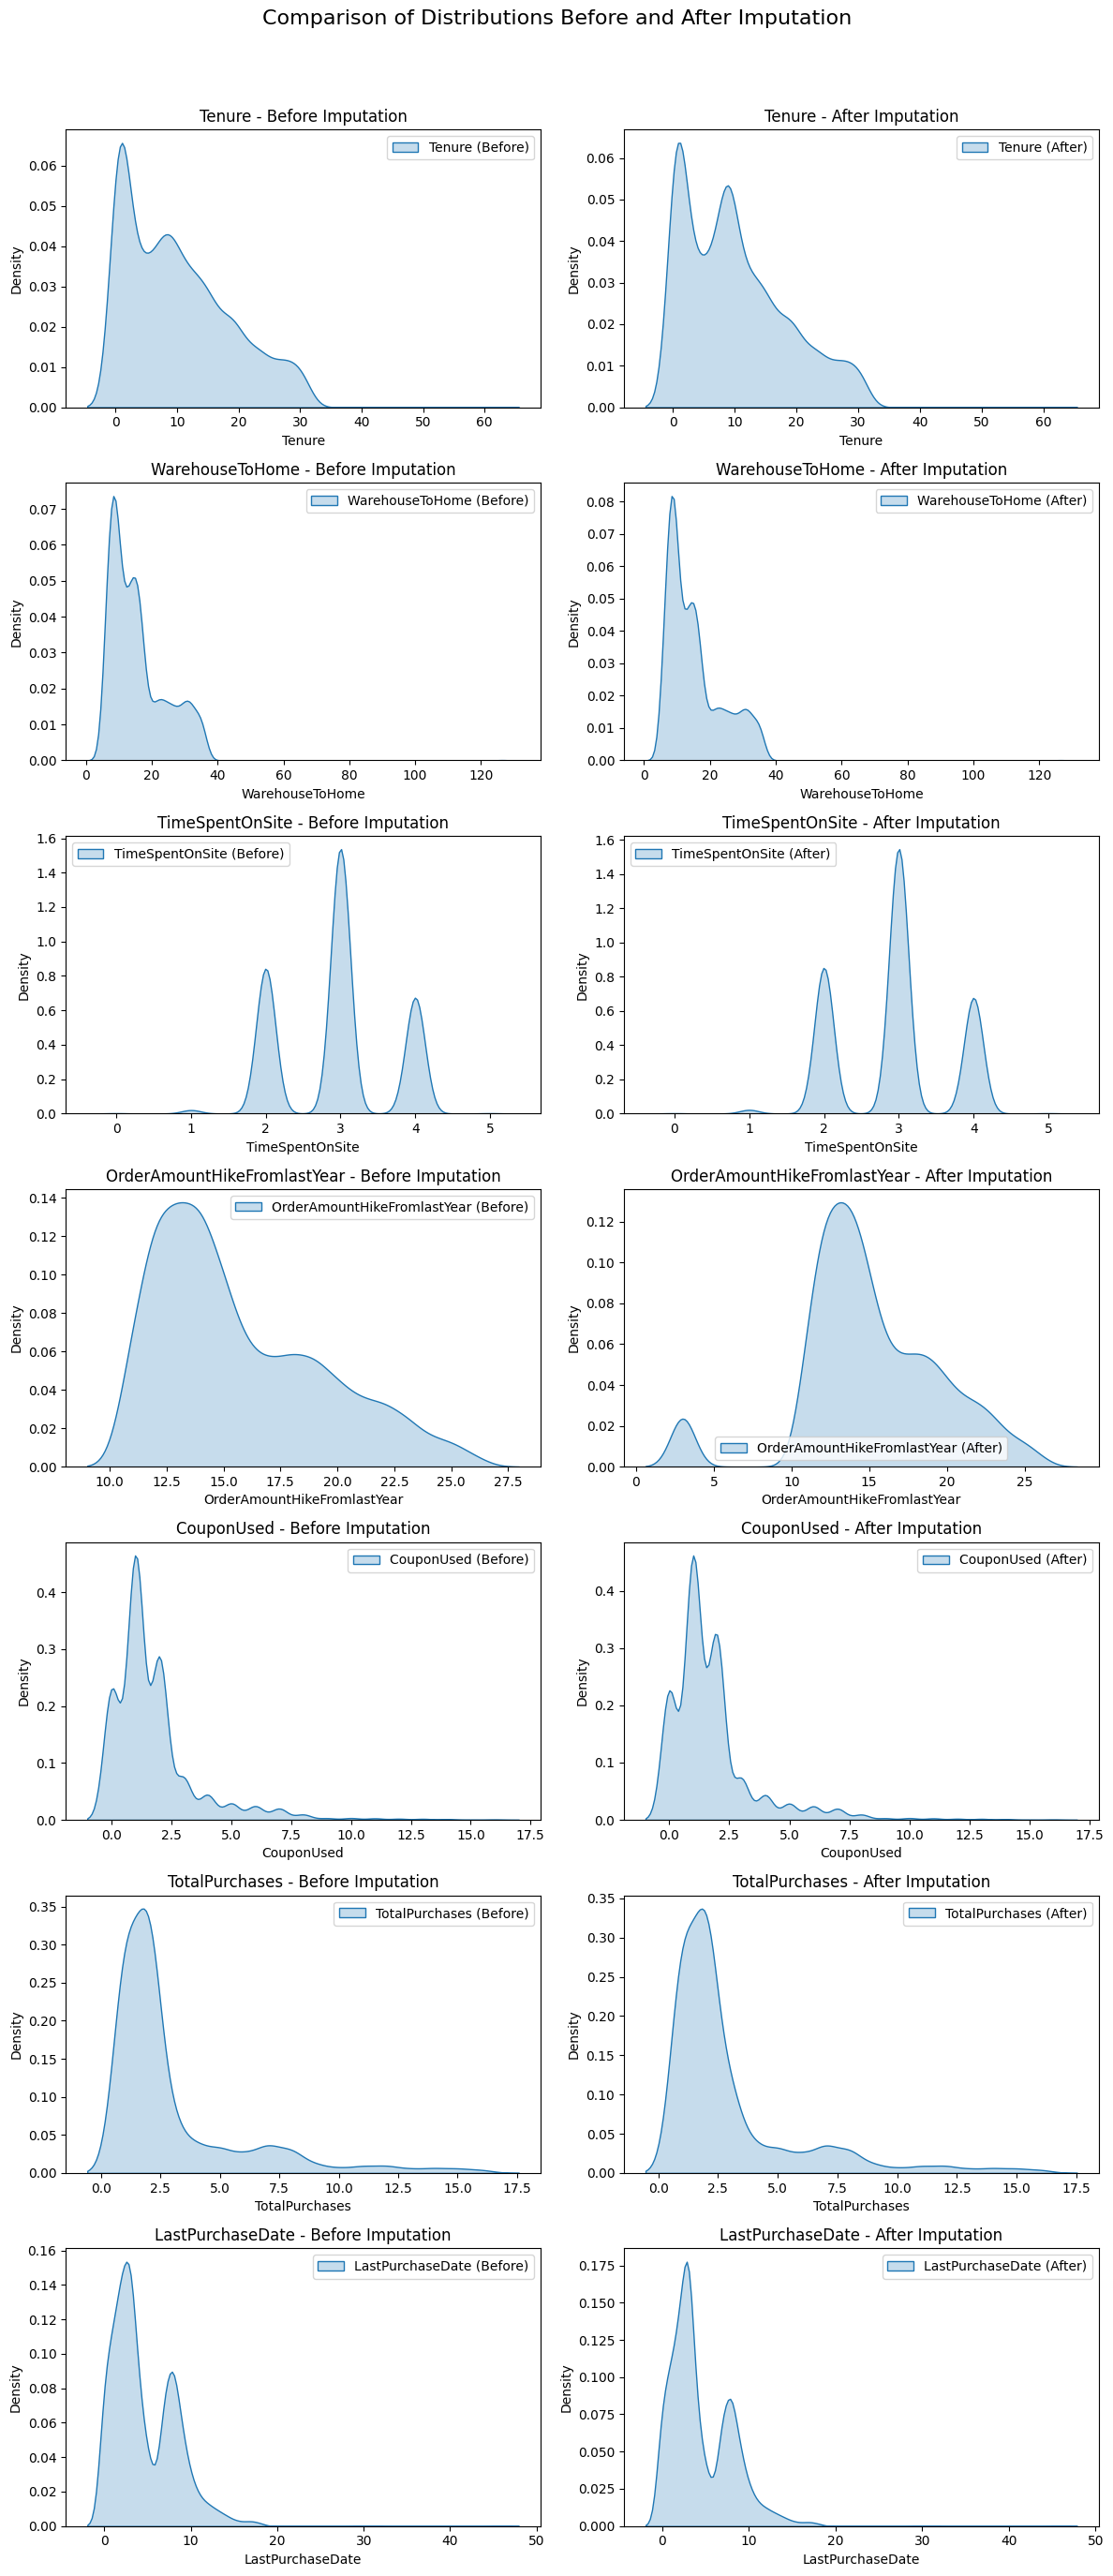

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df (before) and df2 (after) are defined
columns_to_compare = [
    'Tenure', 'WarehouseToHome', 'TimeSpentOnSite', 
    'OrderAmountHikeFromlastYear', 'CouponUsed', 
    'TotalPurchases', 'LastPurchaseDate'
]

# Create subplots to compare distributions before and after imputation
fig, axes = plt.subplots(nrows=len(columns_to_compare), ncols=2, figsize=(12, len(columns_to_compare) * 4))
fig.suptitle("Comparison of Distributions Before and After Imputation", fontsize=16)

for i, col in enumerate(columns_to_compare):
    # Before imputation (original df)
    sns.kdeplot(df[col], label=f'{col} (Before)', fill=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} - Before Imputation')
    axes[i, 0].legend()

    # After imputation (updated df2)
    sns.kdeplot(df2[col], label=f'{col} (After)', fill=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} - After Imputation')
    axes[i, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## 2.2 Feature Engineering

- **RFM feature engineering**

Action: Created and incorporated new features such as 'RFMCustomerSegment' and RFM-related quantiles (i.e., 'RecencyQuantile', 'FrequencyQuantile', 'MonetaryQuantile').

Reference: https://towardsdatascience.com/customer-segmentation-with-kmeans-e499f4ebbd3d



In [13]:
from utils.rfm_helper import perform_ecomm_rfm_analysis

df_engineered = perform_ecomm_rfm_analysis(df2)
df_engineered

Step 1: Data prepared
Step 2: Recency quantiles calculated
Step 3: Frequency quantiles calculated
Step 4: Monetary quantiles calculated
Step 5: Customer segmentation completed
Step 6: Merged results with original data


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,TimeSpentOnSite,NumberOfDeviceRegistered,...,LastPurchaseDate,TotalSpent,Age,WebSiteClickRate,SocialMediaEngagement,AdClickHistory,RFMCustomerSegment,RecencyQuantile,FrequencyQuantile,MonetaryQuantile
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,...,5.0,160,42,0.68,9,0.485928,Average Customer,2,1,2
1,50002,1,9.0,Phone,1,8.0,UPI,Female,3.0,4,...,0.0,121,42,0.68,9,0.485928,Persuadable Customer,4,1,1
2,50003,1,9.0,Phone,1,30.0,Debit Card,Female,2.0,4,...,3.0,120,42,0.68,9,0.485928,Persuadable Customer,3,1,1
3,50004,1,0.0,Phone,3,15.0,Debit Card,Female,2.0,4,...,3.0,134,42,0.68,9,0.485928,Persuadable Customer,3,1,1
4,50005,1,0.0,Phone,1,12.0,CC,Female,2.0,3,...,3.0,130,42,0.68,9,0.485928,Persuadable Customer,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55626,0,10.0,Computer,1,30.0,Credit Card,Female,3.0,2,...,4.0,151,42,0.68,9,0.485928,Average Customer,2,1,2
5626,55627,0,13.0,Mobile Phone,1,13.0,Credit Card,Female,3.0,5,...,3.0,225,42,0.68,9,0.485928,Persuadable Customer,3,1,4
5627,55628,0,1.0,Mobile Phone,1,11.0,Debit Card,Female,3.0,2,...,4.0,186,42,0.68,9,0.485928,Average Customer,2,1,3
5628,55629,0,23.0,Computer,3,9.0,Credit Card,Female,4.0,5,...,9.0,179,42,0.68,9,0.485928,At Risk Customer,1,1,3


# Part 3: Model Training and Evaluation

## 3.1 Prepare Training and Test Sets

In [14]:
df_engineered.dtypes

CustomerID                       int64
Churn                            int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
TimeSpentOnSite                float64
NumberOfDeviceRegistered         int64
PreferedOrderCat                object
CustomerSentimentScore           int64
MaritalStatus                   object
NumberOfAddress                  int64
Complain                         int64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
TotalPurchases                 float64
LastPurchaseDate               float64
TotalSpent                       int64
Age                              int64
WebSiteClickRate               float64
SocialMediaEngagement            int64
AdClickHistory                 float64
RFMCustomerSegment              object
RecencyQuantile          

In [15]:
# Prepare features and target
X = df_engineered.drop(['CustomerID', 'Churn'], axis=1)
y = df_engineered['Churn']

In [16]:
# Classify numerical columns
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

# Classify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [17]:
# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [18]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, stratify=y)

In [19]:
# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [20]:
# Extract feature names from sklearn pipeline to be used for decision tree
feature_names = []
for name, transformer, columns in preprocessor.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        feature_names.extend(columns)  # Add original column names if not transformed

print("Feature names after preprocessing:")
print(feature_names)

Feature names after preprocessing:
['Tenure', 'CityTier', 'WarehouseToHome', 'TimeSpentOnSite', 'NumberOfDeviceRegistered', 'CustomerSentimentScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'TotalPurchases', 'LastPurchaseDate', 'TotalSpent', 'Age', 'WebSiteClickRate', 'SocialMediaEngagement', 'AdClickHistory', 'RecencyQuantile', 'FrequencyQuantile', 'MonetaryQuantile', 'PreferredLoginDevice_Mobile Phone', 'PreferredLoginDevice_Phone', 'PreferredPaymentMode_COD', 'PreferredPaymentMode_Cash on Delivery', 'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card', 'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI', 'PreferedOrderCat_Grocery', 'PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile', 'PreferedOrderCat_Mobile Phone', 'PreferedOrderCat_Others', 'MaritalStatus_Married', 'MaritalStatus_Single', 'RFMCustomerSegment_Average Customer', 'RFMCustomerSegment_High Value Customer', 'RFMCustomerSegment_Loyal Customer', 'RF

## 3.2 Train and Evaluate Models

In [21]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

def train_evaluate_decision_tree(X_train, X_test, y_train, y_test):
    # Initialize the Decision Tree model
    decision_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
    
    # Train the model
    decision_tree.fit(X_train, y_train)
    
    # Make predictions
    y_pred = decision_tree.predict(X_test)
    y_pred_proba = decision_tree.predict_proba(X_test)[:, 1]
    
    # Calculate performance metrics
    results = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba)
    }
    
    return results, decision_tree


# Train and evaluate the Decision Tree
results, trained_dt_model = train_evaluate_decision_tree(X_train_processed, X_test_processed, y_train, y_test)

# Display results
results_df = pd.DataFrame([results], index=['Decision Tree'])
print("Decision Tree Performance Metrics:")
display(results_df)


Decision Tree Performance Metrics:


,Accuracy,F1 Score,AUC
Decision Tree,0.889876,0.6125,0.884773


## 3.3 Decision Tree splitting rules

- Decision Tree Split rules

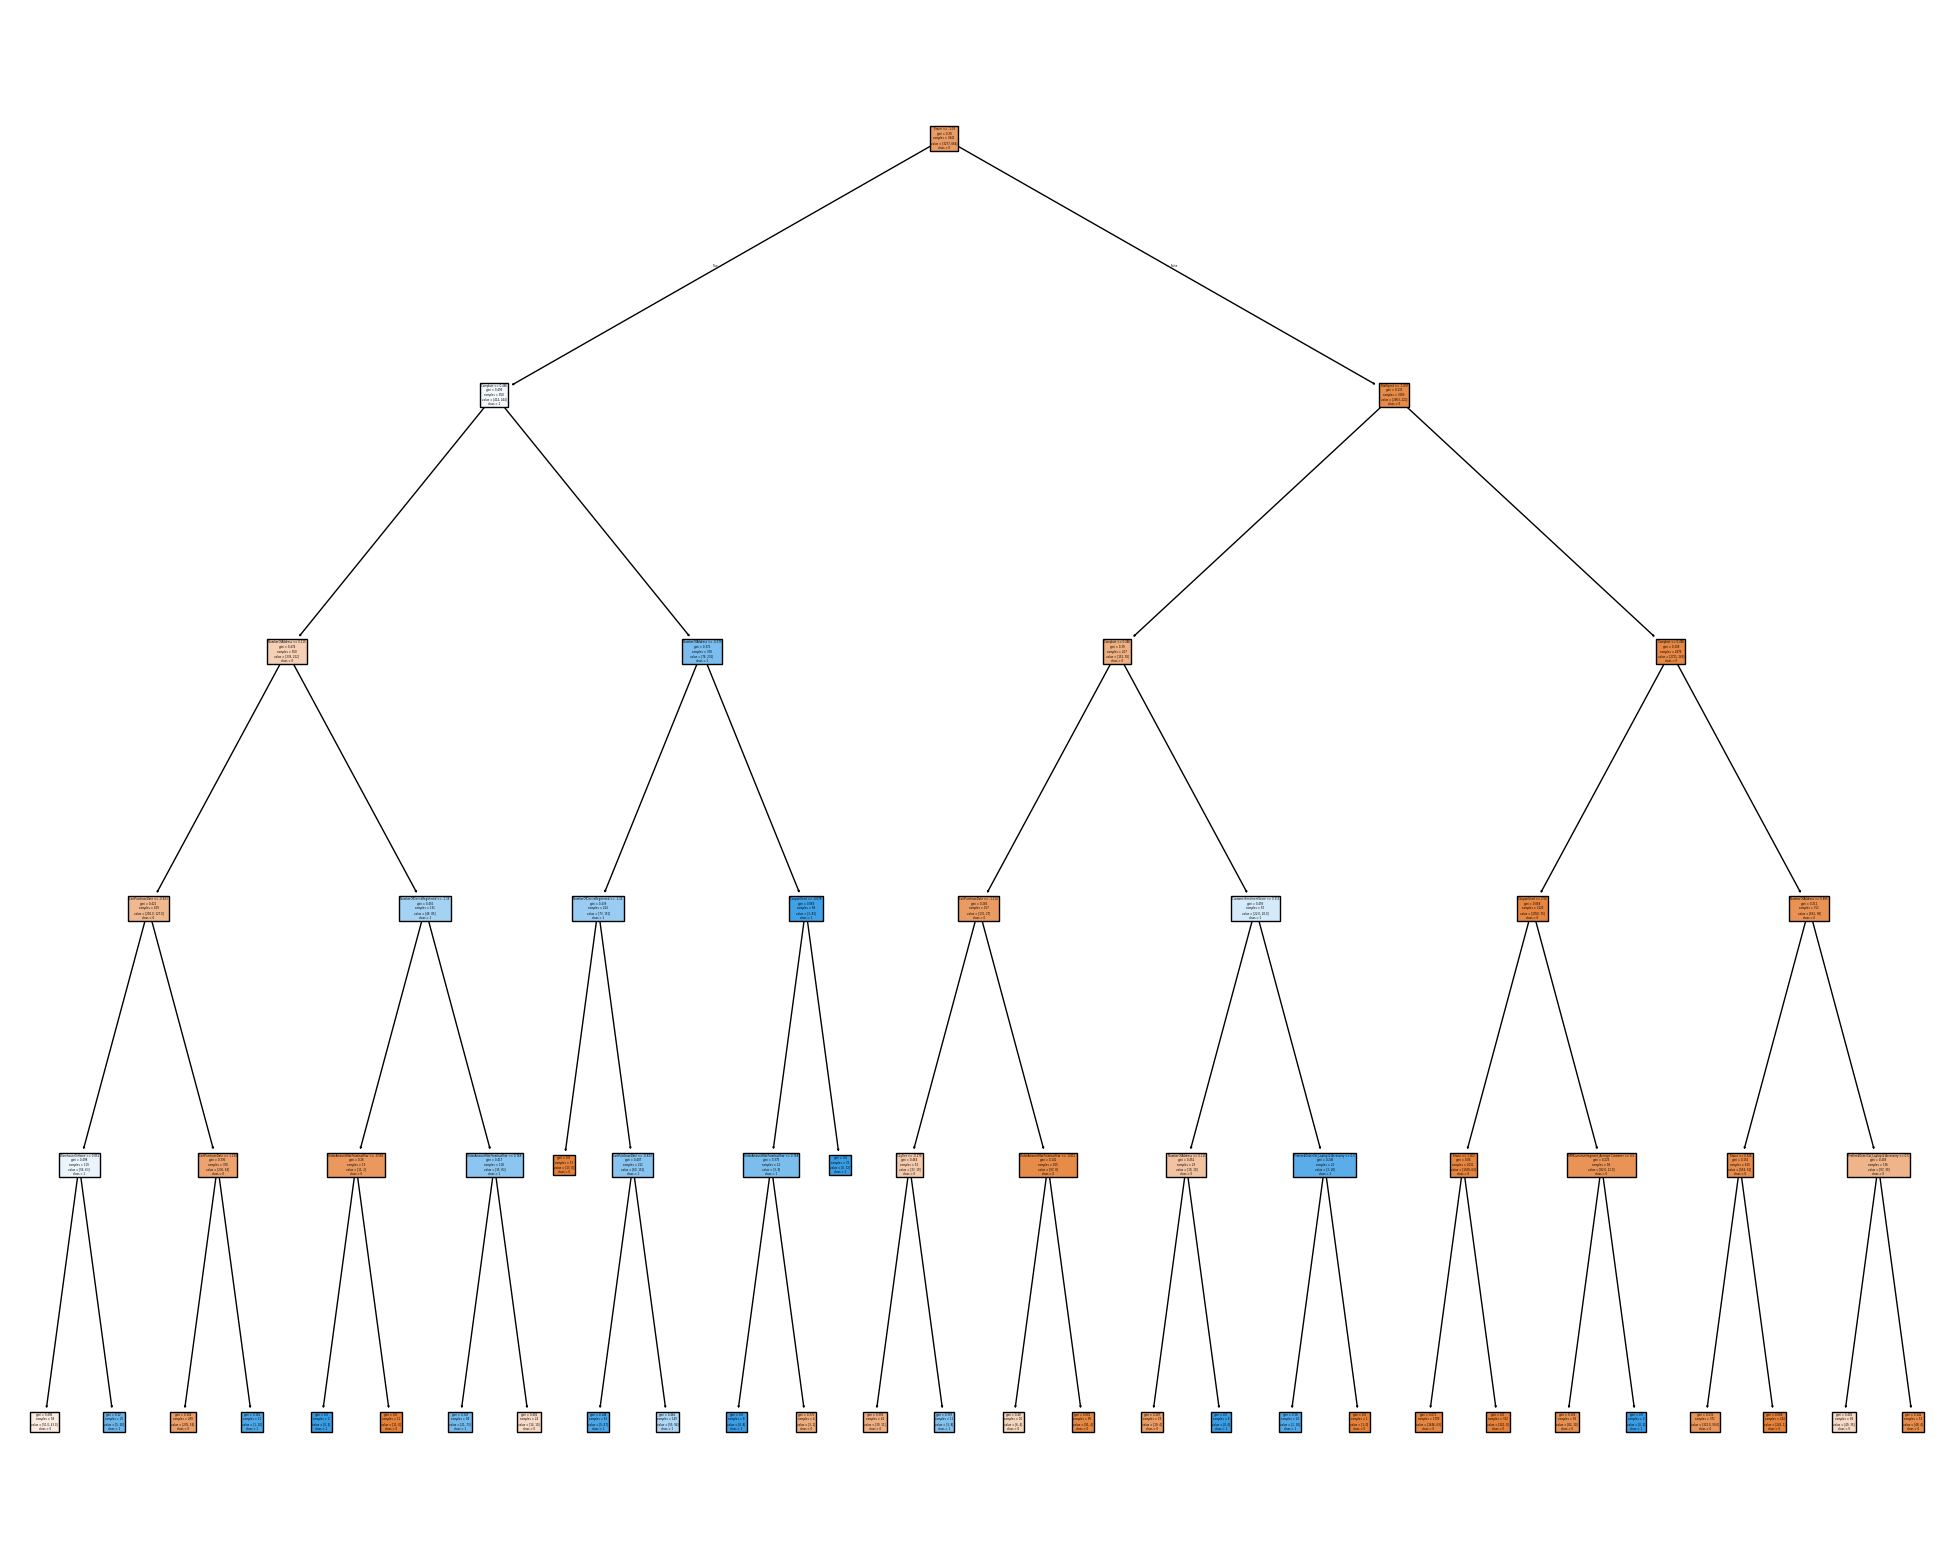

In [23]:
from sklearn import tree
import matplotlib.pyplot as plt

# generate class_names
class_names = [str(i) for i in np.unique(y)]

fig = plt.figure(figsize=(25,20))
tree.plot_tree(trained_dt_model,
              feature_names=feature_names,
                   class_names=class_names ,
                   filled=True)
plt.show()

- Saving Decision Tree as image for clearer view

In [24]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# generate class_names
class_names = np.unique(y).astype(str).tolist()

# Export the tree in Graphviz format
dot_data = export_graphviz(
    trained_dt_model,
    out_file=None,  # We don't need a file output, we'll render it directly
    feature_names=feature_names,
    class_names=class_names ,
    filled=True,  # Color nodes by class
    rounded=True, # Round node corners
    special_characters=True  # Use special characters like `<=`
)

# Save the DOT data to a file
with open("./images/decision_tree.dot", "w") as f:
    f.write(dot_data)

## 3.4 Feature Importance for Decision Tree

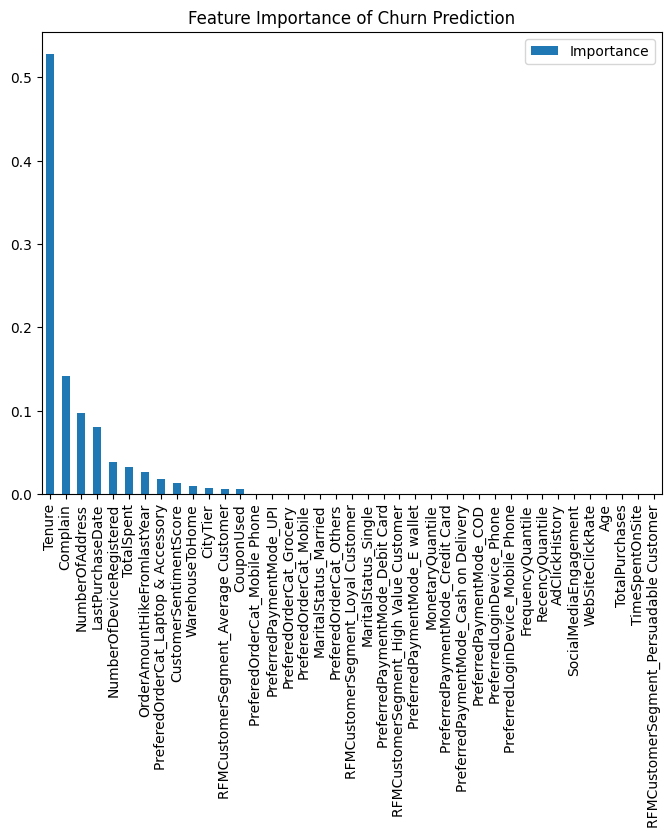

In [25]:
dt_feat_importances = pd.DataFrame(trained_dt_model.feature_importances_, index=feature_names, columns=["Importance"])
dt_feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
dt_feat_importances.plot(kind='bar', figsize=(8,6))
plt.title("Feature Importance of Churn Prediction")
plt.show()

# Part 4: Clustering Analysis

Reference: 
- https://365datascience.com/tutorials/python-tutorials/pca-k-means/
- https://drlee.io/the-ultimate-step-by-step-guide-to-data-mining-with-pca-and-kmeans-83a2bcfdba7d
- https://medium.com/data-science-indo/mall-customers-clustering-analysis-da594bd2718b
- https://towardsdatascience.com/customer-segmentation-with-kmeans-e499f4ebbd3d

## 4.1 Perform K-Means Clustering

In [26]:
from sklearn.decomposition import PCA

# Applying PCA with the optimal number of components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_processed)

# The pca_result is an array with the transformed features

In [27]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_train_pca)

- Visualization of Kmeans clustering

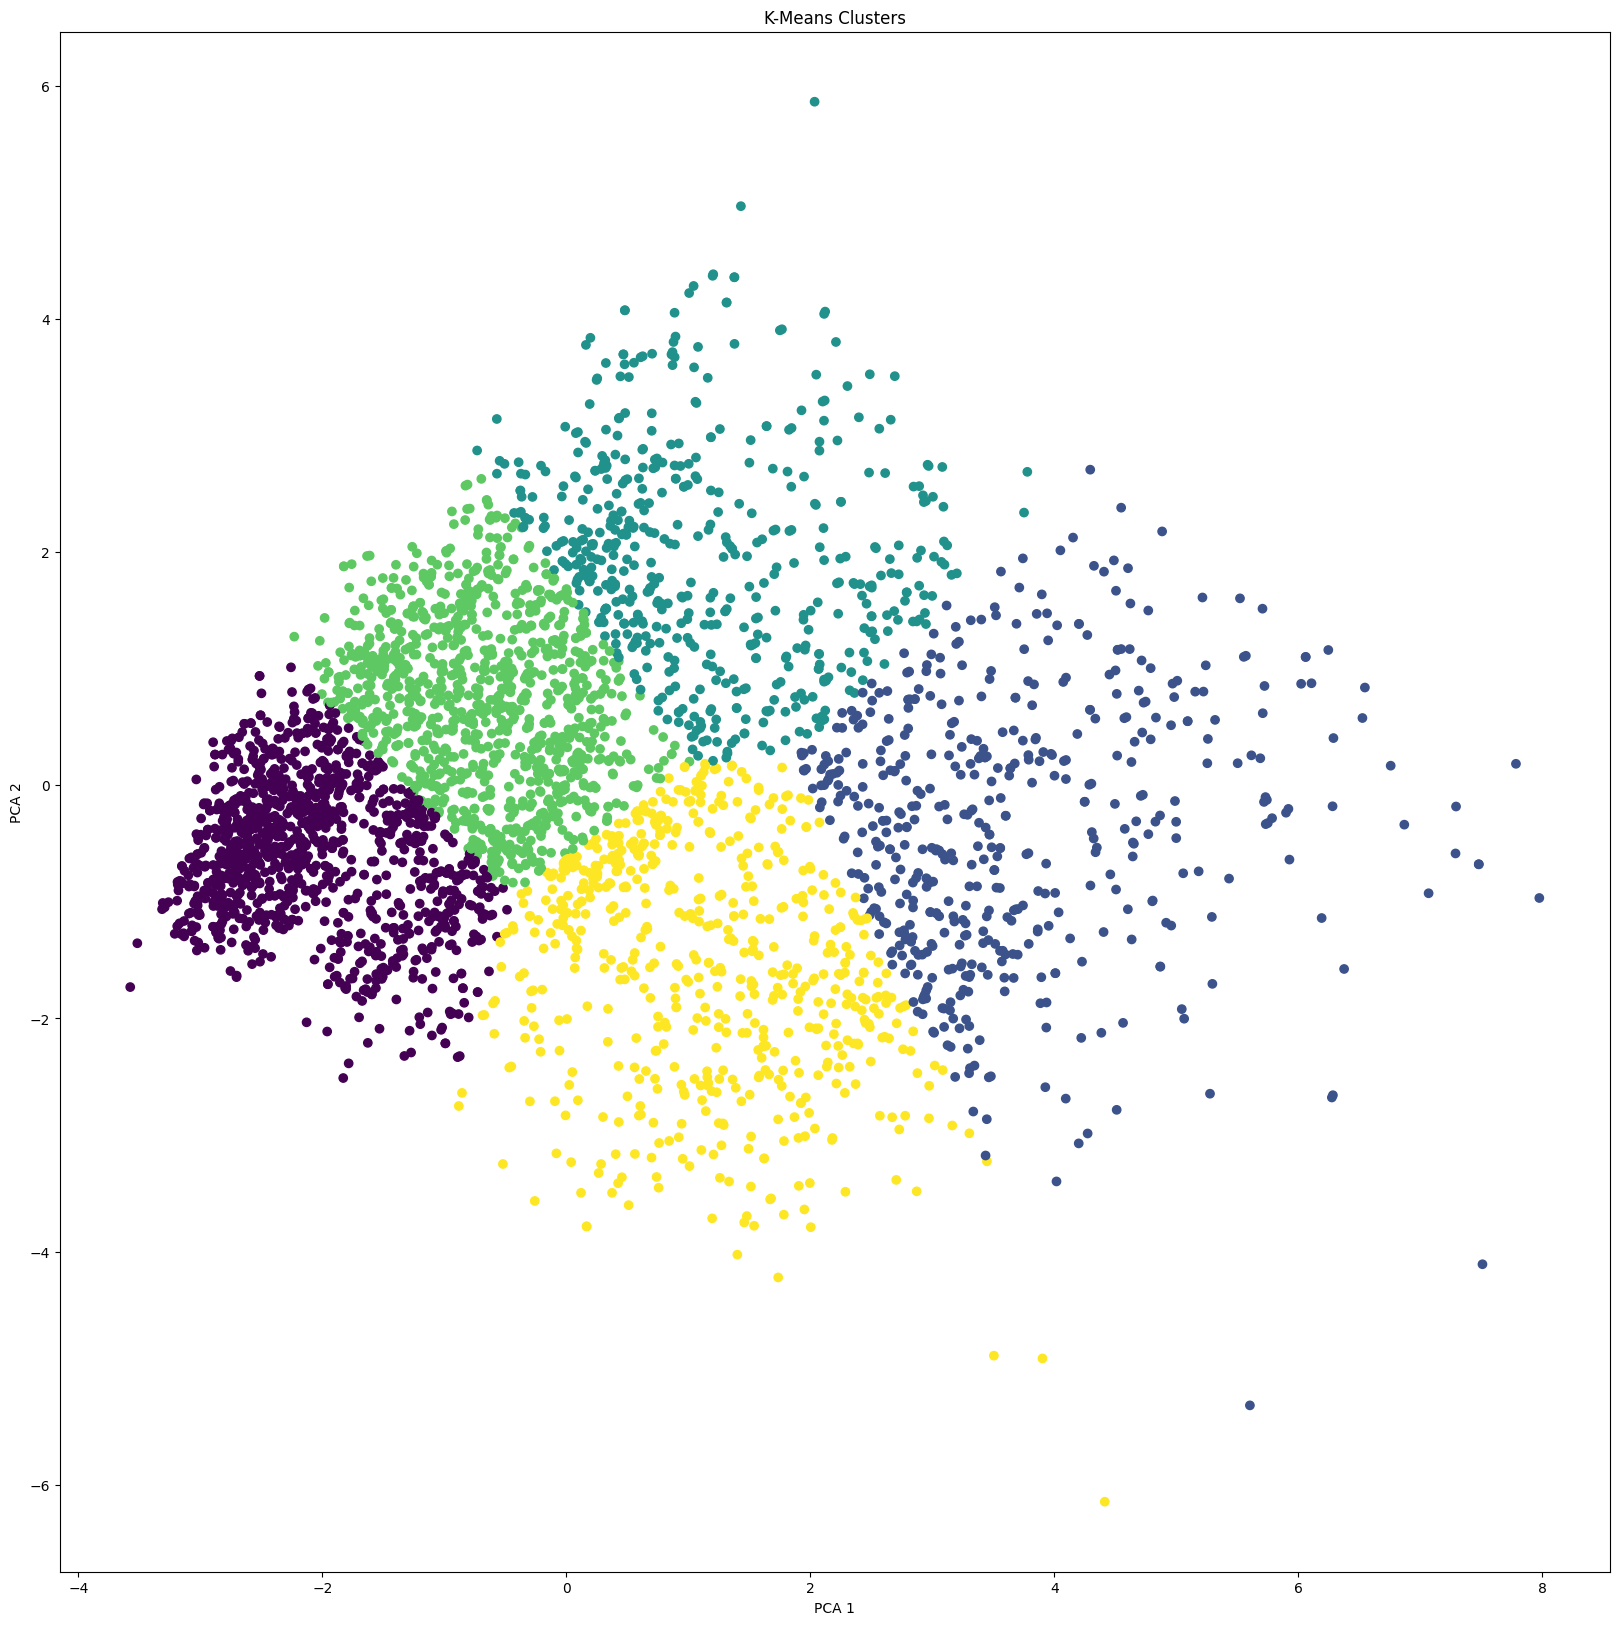

In [47]:
%matplotlib inline

# K-Means clusters
# plt.subplot(131)
plt.figure(figsize=(20, 20))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
            c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [29]:
# Ensure 'clusters' is aligned with X_train_processed
train_kmeans_df= pd.DataFrame(X_train_processed, columns=feature_names)

# Add the cluster labels to the DataFrame
train_kmeans_df['Segment'] = np.asarray(kmeans_labels).flatten()

In [30]:
train_kmeans_df

,Tenure,CityTier,WarehouseToHome,TimeSpentOnSite,NumberOfDeviceRegistered,CustomerSentimentScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,...,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single,RFMCustomerSegment_Average Customer,RFMCustomerSegment_High Value Customer,RFMCustomerSegment_Loyal Customer,RFMCustomerSegment_Persuadable Customer,Segment
0,-0.132544,-0.723700,0.553834,-1.287337,-0.673054,-0.045175,-0.860353,-0.625776,0.203930,-0.408504,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,-0.371882,-0.723700,-0.994659,1.482740,-0.673054,-0.045175,0.699643,-0.625776,1.105686,-0.004458,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2
2,-1.209565,-0.723700,-0.875544,-1.287337,-2.619132,-0.765968,-0.860353,-0.625776,-0.697825,-0.408504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,0.944478,-0.723700,-0.399085,0.097701,1.273025,-0.045175,0.309644,-0.625776,-0.021509,-0.408504,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3
4,0.705139,-0.723700,-0.756429,0.097701,0.299985,-0.045175,1.089642,-0.625776,-2.726775,0.129490,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,-1.209565,-0.723700,-1.113774,0.097701,1.273025,-1.486761,-0.080355,-0.625776,-0.246947,0.129490,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
3937,0.705139,0.366553,-0.756429,1.482740,-1.646093,1.396411,1.869641,-0.625776,0.429369,0.129490,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3
3938,-0.491551,1.456806,-1.113774,-1.287337,-2.619132,1.396411,-0.470354,-0.625776,0.880247,-0.946499,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
3939,2.260837,-0.723700,-0.756429,1.482740,1.273025,-1.486761,2.259640,-0.625776,1.331125,-0.408504,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3


- Distribution Plot for KMeans clustering

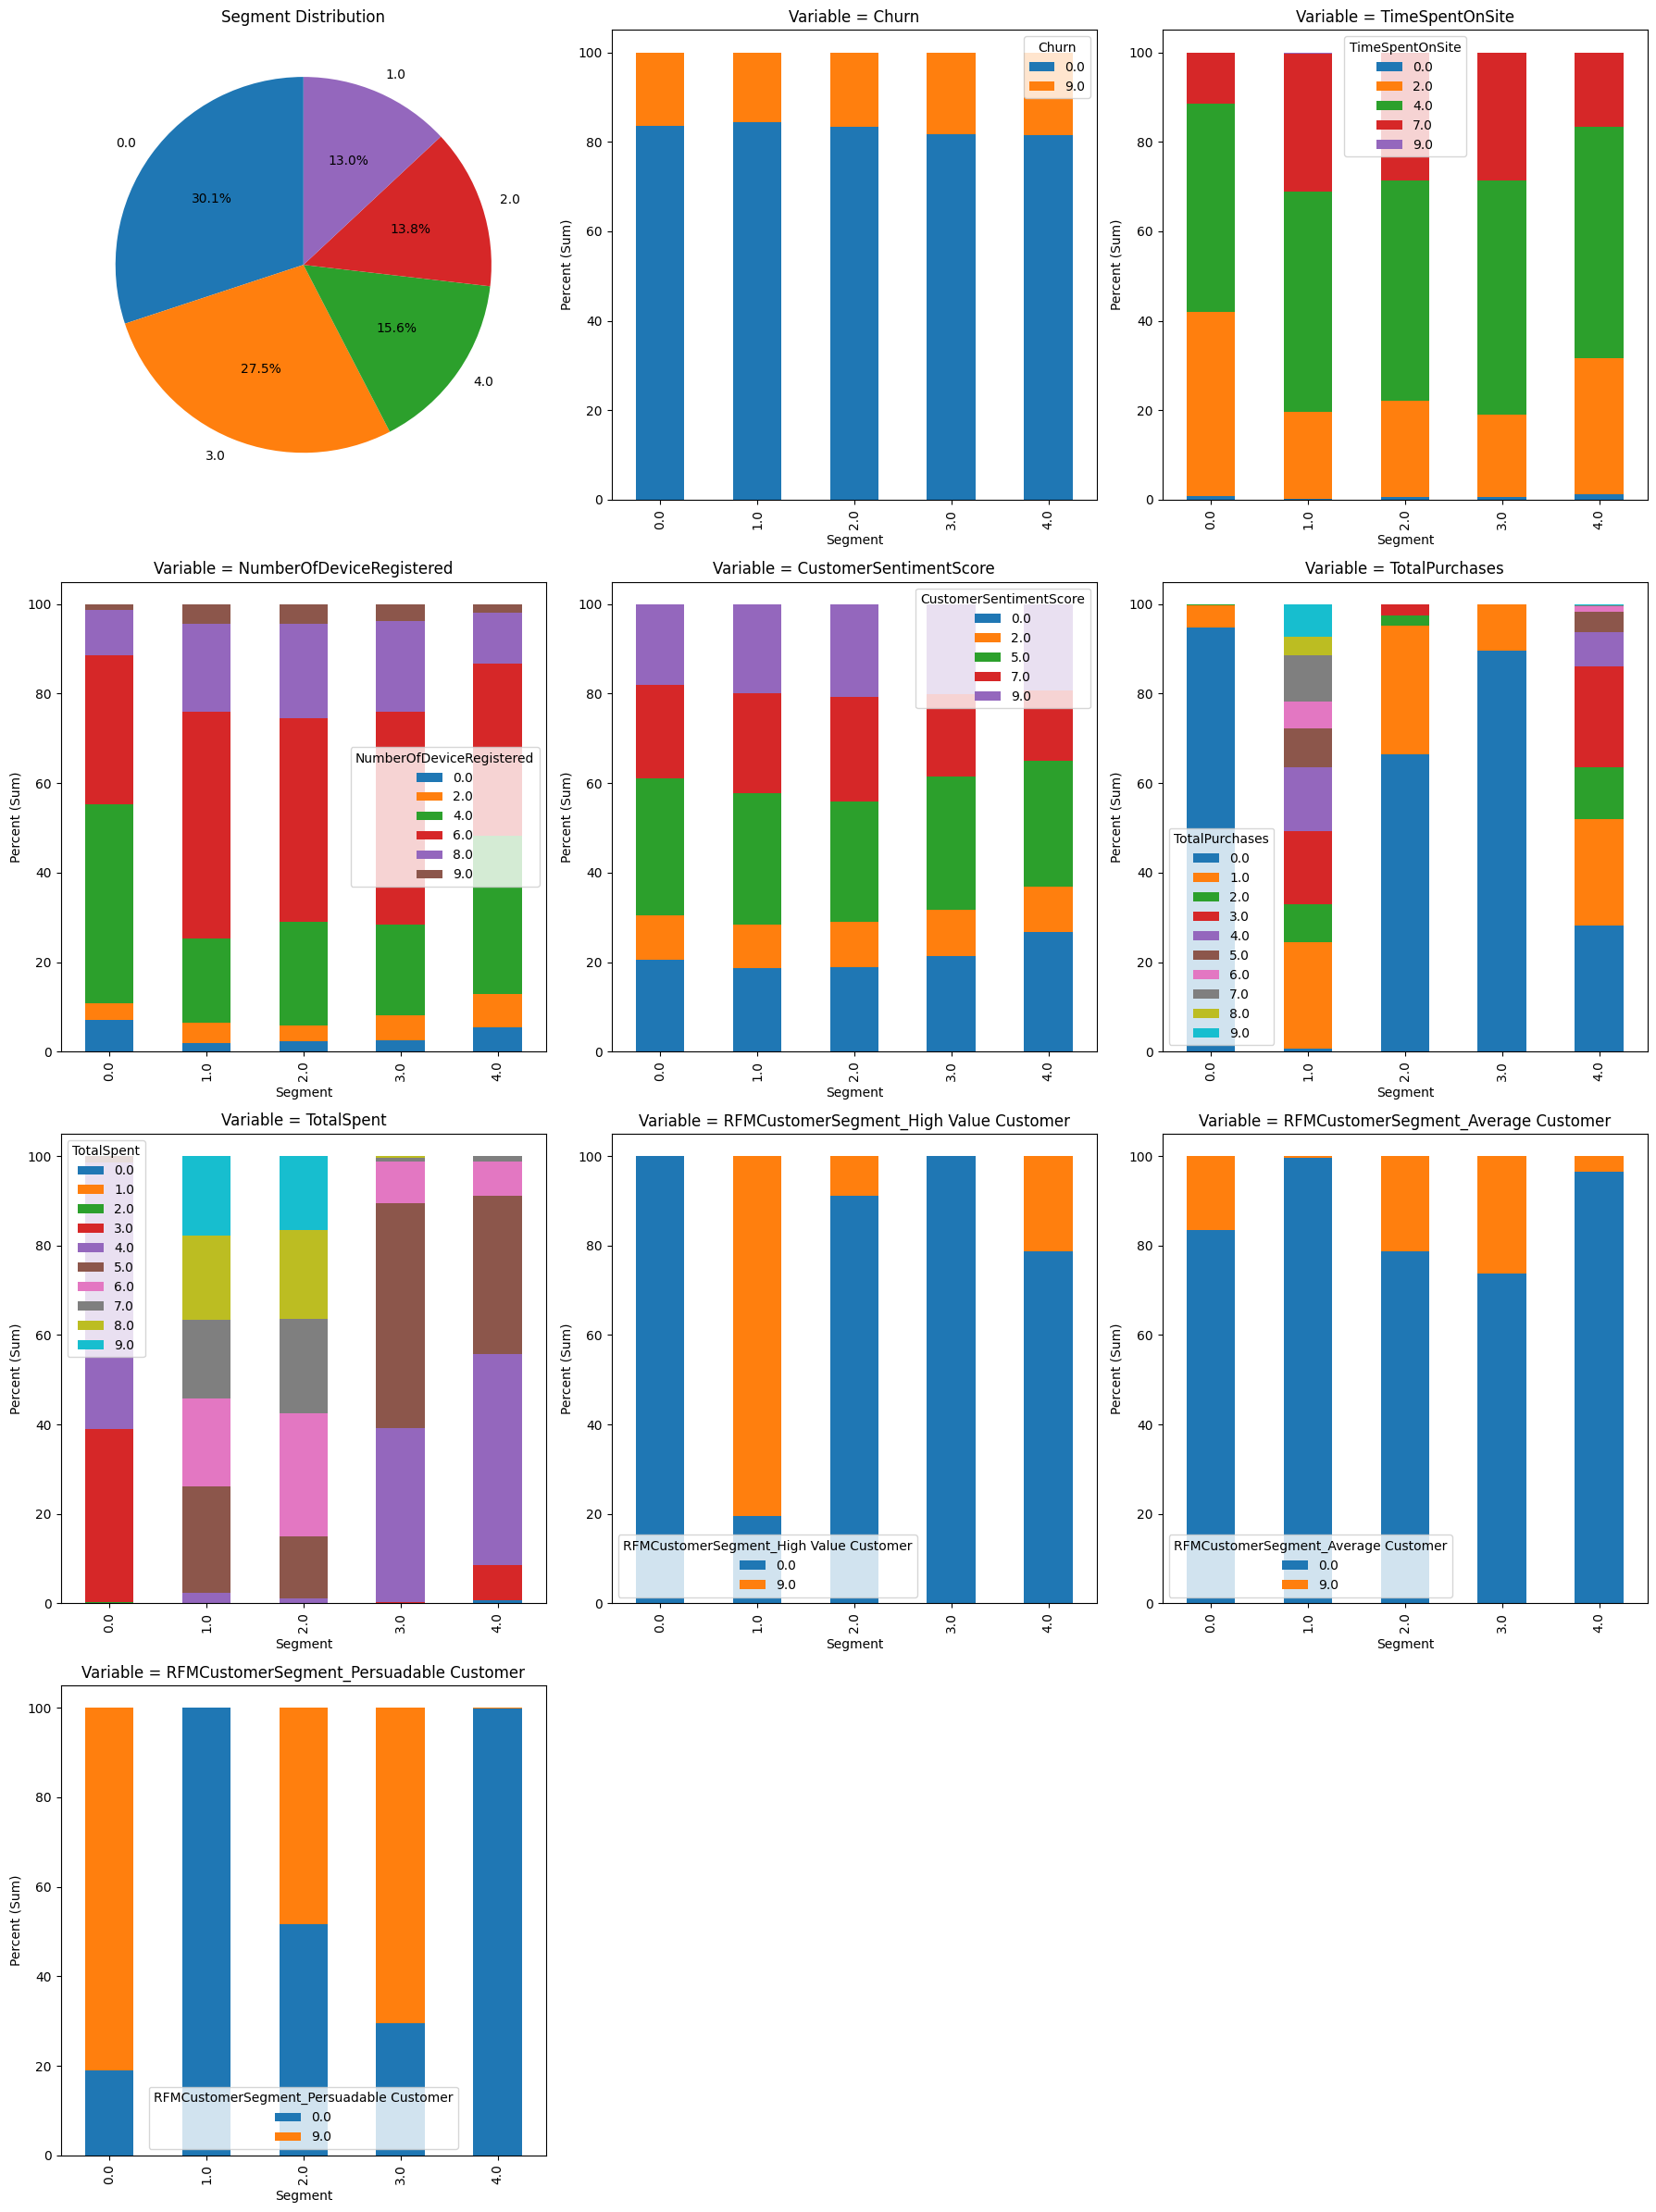

In [33]:
from utils.plot_helper import plot_distributions

train_kmeans_df_with_Y = pd.concat([train_kmeans_df, y_train], axis=1)
plot_distributions(train_kmeans_df_with_Y, 
        variables=["Churn", "TimeSpentOnSite",
                        "NumberOfDeviceRegistered",
                        "CustomerSentimentScore", 
                        "TotalPurchases","TotalSpent", 
                        "RFMCustomerSegment_High Value Customer",
                        "RFMCustomerSegment_Average Customer",
                        "RFMCustomerSegment_Persuadable Customer"]) #train_kmeans_df.columns[:-1])

## 4.2 Perform DBSCAN Clustering

Reference: https://www.datacamp.com/tutorial/dbscan-clustering-algorithm

In [34]:
# Perform DBSCAN clustering
epsilon = 0.15  # Chosen based on k-distance graph
min_samples = 5  # 2 * num_features (2D data)
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_train_pca)

In [35]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_ = list(dbscan_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 45
Estimated number of noise points: 541


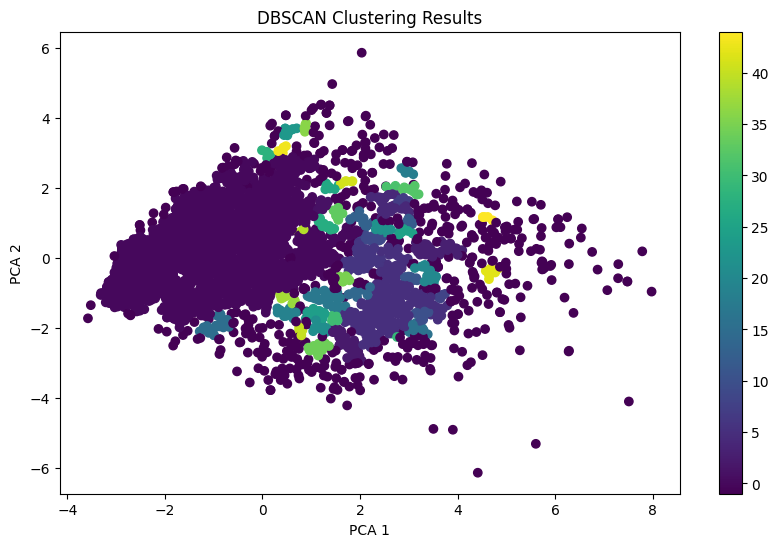

In [36]:
# Visualize the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=dbscan_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('DBSCAN Clustering Results')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [37]:
# Ensure 'clusters' is aligned with X_train_processed
train_dbscan_df = pd.DataFrame(X_train_processed, columns=feature_names)

# Add the cluster labels to the DataFrame
train_dbscan_df['Segment'] = np.asarray(dbscan_labels).flatten()
train_dbscan_df

,Tenure,CityTier,WarehouseToHome,TimeSpentOnSite,NumberOfDeviceRegistered,CustomerSentimentScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,...,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single,RFMCustomerSegment_Average Customer,RFMCustomerSegment_High Value Customer,RFMCustomerSegment_Loyal Customer,RFMCustomerSegment_Persuadable Customer,Segment
0,-0.132544,-0.723700,0.553834,-1.287337,-0.673054,-0.045175,-0.860353,-0.625776,0.203930,-0.408504,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,-0.371882,-0.723700,-0.994659,1.482740,-0.673054,-0.045175,0.699643,-0.625776,1.105686,-0.004458,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
2,-1.209565,-0.723700,-0.875544,-1.287337,-2.619132,-0.765968,-0.860353,-0.625776,-0.697825,-0.408504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,0.944478,-0.723700,-0.399085,0.097701,1.273025,-0.045175,0.309644,-0.625776,-0.021509,-0.408504,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
4,0.705139,-0.723700,-0.756429,0.097701,0.299985,-0.045175,1.089642,-0.625776,-2.726775,0.129490,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,-1.209565,-0.723700,-1.113774,0.097701,1.273025,-1.486761,-0.080355,-0.625776,-0.246947,0.129490,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
3937,0.705139,0.366553,-0.756429,1.482740,-1.646093,1.396411,1.869641,-0.625776,0.429369,0.129490,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
3938,-0.491551,1.456806,-1.113774,-1.287337,-2.619132,1.396411,-0.470354,-0.625776,0.880247,-0.946499,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
3939,2.260837,-0.723700,-0.756429,1.482740,1.273025,-1.486761,2.259640,-0.625776,1.331125,-0.408504,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0


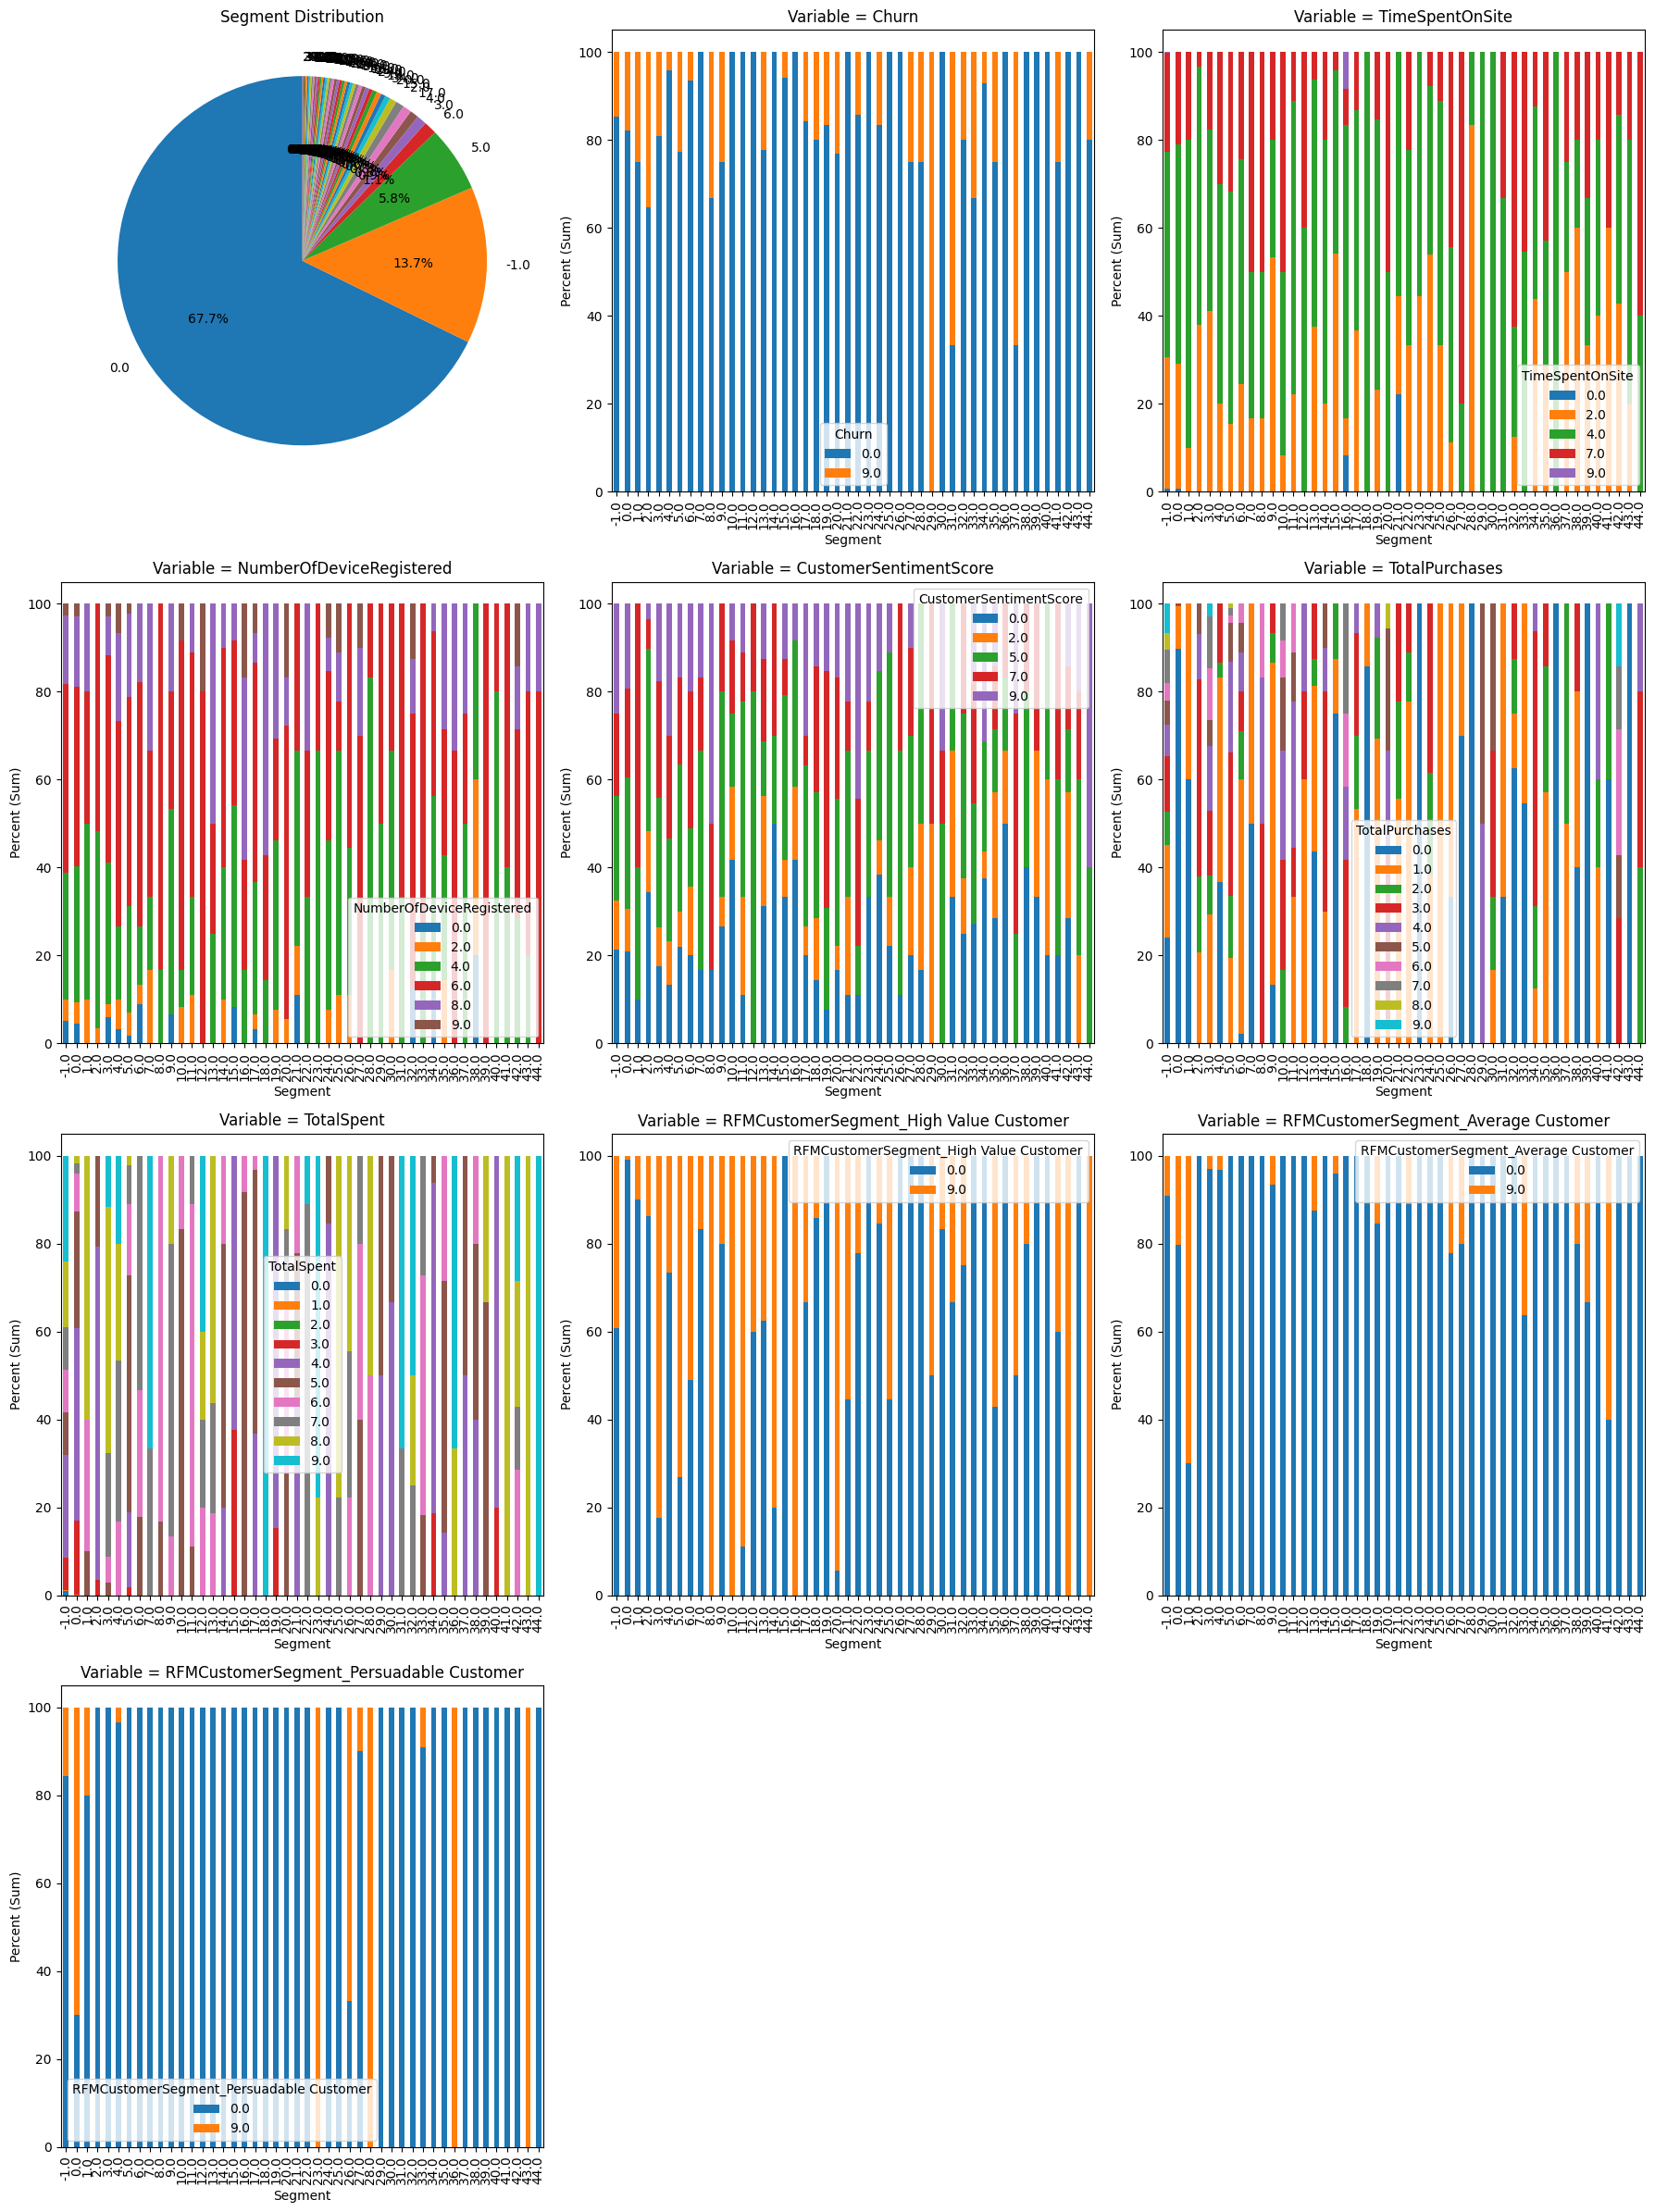

In [49]:
train_dbscan_df_with_Y = pd.concat([train_dbscan_df, y_train], axis=1)
plot_distributions(train_dbscan_df_with_Y, ["Churn", "TimeSpentOnSite",
                        "NumberOfDeviceRegistered",
                        "CustomerSentimentScore", 
                        "TotalPurchases","TotalSpent", 
                        "RFMCustomerSegment_High Value Customer",
                        "RFMCustomerSegment_Average Customer",
                        "RFMCustomerSegment_Persuadable Customer"])

# Part 5: Ensemble method - Bagging and Boosting

In [39]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


# Define a function for evaluation
def evaluate_model(model_name, y_true, y_pred, y_proba):
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_proba):.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("\n")


## 5.1 Bagging Techniques

In [40]:
# --- Train Bagging Classifier ---
bagging = BaggingClassifier(n_estimators=100, random_state=42)
bagging.fit(X_train_processed, y_train)
bagging_preds = bagging.predict(X_test_processed)
bagging_proba = bagging.predict_proba(X_test_processed)[:, 1]
evaluate_model("Bagging Classifier", y_test, bagging_preds, bagging_proba)

--- Bagging Classifier ---
Accuracy: 0.9621
F1 Score: 0.8824
AUC-ROC: 0.9863

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1405
           1       0.92      0.85      0.88       284

    accuracy                           0.96      1689
   macro avg       0.95      0.92      0.93      1689
weighted avg       0.96      0.96      0.96      1689





In [41]:
# --- Train Random Forest Classifier ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_processed, y_train)
rf_preds = rf.predict(X_test_processed)
rf_proba = rf.predict_proba(X_test_processed)[:, 1]
evaluate_model("Random Forest", y_test, rf_preds, rf_proba)

--- Random Forest ---
Accuracy: 0.9603
F1 Score: 0.8714
AUC-ROC: 0.9864

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1405
           1       0.96      0.80      0.87       284

    accuracy                           0.96      1689
   macro avg       0.96      0.90      0.92      1689
weighted avg       0.96      0.96      0.96      1689





## 5.2 Boosting Techniques

In [42]:
# --- Train AdaBoost Classifier ---
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost.fit(X_train_processed, y_train)
adaboost_preds = adaboost.predict(X_test_processed)
adaboost_proba = adaboost.predict_proba(X_test_processed)[:, 1]
evaluate_model("AdaBoost", y_test, adaboost_preds, adaboost_proba)

--- AdaBoost ---
Accuracy: 0.8863
F1 Score: 0.6082
AUC-ROC: 0.9052

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93      1405
           1       0.72      0.52      0.61       284

    accuracy                           0.89      1689
   macro avg       0.82      0.74      0.77      1689
weighted avg       0.88      0.89      0.88      1689





In [43]:
# --- Train XGBoost Classifier ---
xgb = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb.fit(X_train_processed, y_train)
xgb_preds = xgb.predict(X_test_processed)
xgb_proba = xgb.predict_proba(X_test_processed)[:, 1]
evaluate_model("XGBoost", y_test, xgb_preds, xgb_proba)

--- XGBoost ---
Accuracy: 0.9739
F1 Score: 0.9203
AUC-ROC: 0.9858

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1405
           1       0.95      0.89      0.92       284

    accuracy                           0.97      1689
   macro avg       0.96      0.94      0.95      1689
weighted avg       0.97      0.97      0.97      1689





## 5.3 ROC curve for Bagging and Boosting Models

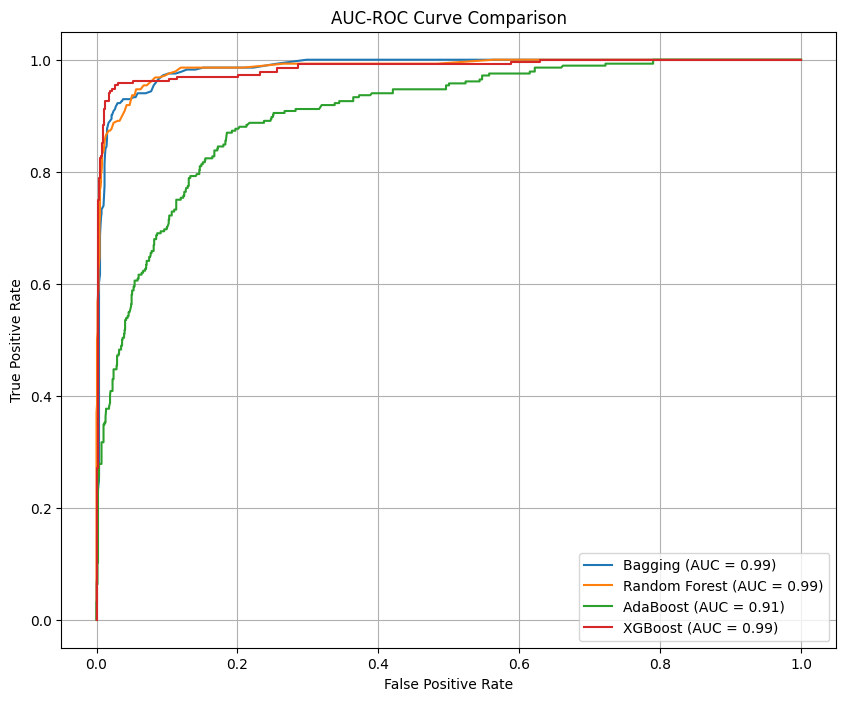

In [44]:
# --- Visualization of AUC-ROC for comparison ---
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# Bagging
fpr_bagging, tpr_bagging, _ = roc_curve(y_test, bagging_proba)
auc_bagging = auc(fpr_bagging, tpr_bagging)
plt.plot(fpr_bagging, tpr_bagging, label=f"Bagging (AUC = {auc_bagging:.2f})")

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")

# AdaBoost
fpr_adaboost, tpr_adaboost, _ = roc_curve(y_test, adaboost_proba)
auc_adaboost = auc(fpr_adaboost, tpr_adaboost)
plt.plot(fpr_adaboost, tpr_adaboost, label=f"AdaBoost (AUC = {auc_adaboost:.2f})")

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})")

# Plot settings
plt.title('AUC-ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## 6.1 Deploy and Predict with best model

In [52]:
from joblib import dump, load  # Recommended for larger models

model_filename = './model/xgboost_model.joblib'
dump(xgb, model_filename)
print(f"Model saved to {model_filename}")

Model saved to ./model/xgboost_model.joblib


In [54]:
# 9. Load the scaler
with open(model_filename, 'rb') as file:
   deployed_xgb = load(file)
print("XGB model is loaded successfully.")

XGB model is loaded successfully.


In [55]:
xgb_proba = deployed_xgb.predict_proba(X_test_processed)[:, 1]
xgb_proba


array([3.0964633e-04, 1.1794366e-02, 5.7166787e-03, ..., 1.8306282e-05,
       2.5132895e-03, 1.4144519e-02], dtype=float32)